## Install Dependencies

In [3]:
#!pip install tensorflow opencv-python matplotlib

## Import Dependencies

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Remove Dodgy Images

In [2]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg','jpg','bmp','png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))





## Load Data

In [61]:
tf.data.Dataset??

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 4000 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

In [10]:
batch[0].shape

(32, 256, 256, 3)

In [11]:
batch[1]

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1])

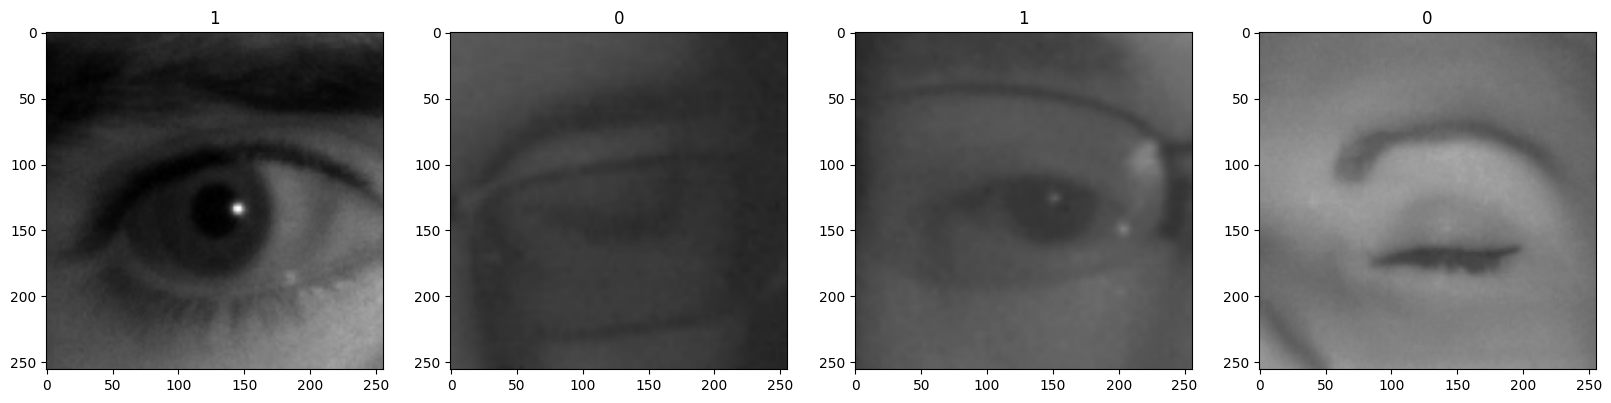

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessig Data - Scale Data & Split Data

In [13]:
#Scale Data
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()[0].min(), data.as_numpy_iterator().next()[0].max()

(0.0010416667, 1.0)

In [15]:
#Split Data
len(data)

125

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)
train_size, val_size, test_size

(87, 26, 12)

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Build Deep Learning Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
#
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20,validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
87/87 [==============================] - 184s 2s/step - loss: 0.3097 - accuracy: 0.8337 - val_loss: 0.1085 - val_accuracy: 0.9579
Epoch 2/20
87/87 [==============================] - 165s 2s/step - loss: 0.0515 - accuracy: 0.9824 - val_loss: 0.0480 - val_accuracy: 0.9820
Epoch 3/20
87/87 [==============================] - 141s 2s/step - loss: 0.0498 - accuracy: 0.9831 - val_loss: 0.0720 - val_accuracy: 0.9916
Epoch 4/20
87/87 [==============================] - 165s 2s/step - loss: 0.0456 - accuracy: 0.9842 - val_loss: 0.0633 - val_accuracy: 0.9760
Epoch 5/20
87/87 [==============================] - 155s 2s/step - loss: 0.0324 - accuracy: 0.9878 - val_loss: 0.0328 - val_accuracy: 0.9880
Epoch 6/20
87/87 [==============================] - 163s 2s/step - loss: 0.0174 - accuracy: 0.9939 - val_loss: 0.0176 - val_accuracy: 0.9928
Epoch 7/20
87/87 [==============================] - 154s 2s/step - loss: 0.0634 - accuracy: 0.9802 - val_loss: 0.0209 - val_accuracy: 0.9940
Epoch 8/20
87

## Plot Performance

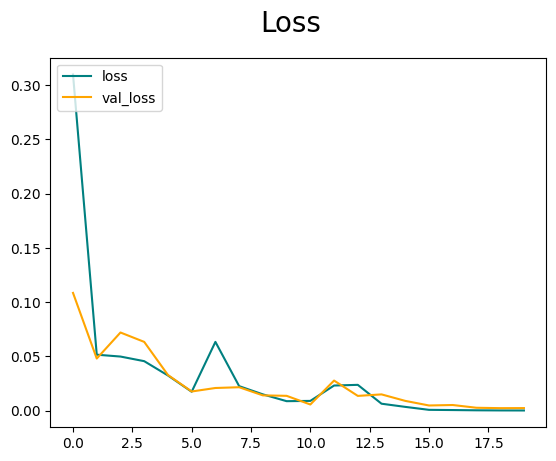

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

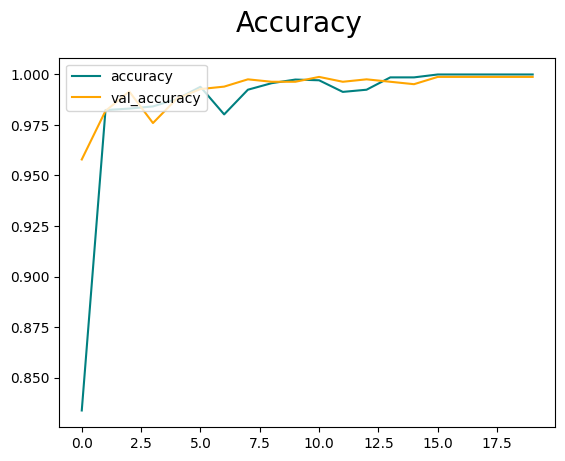

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate Performance 

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 438ms/step


In [32]:
print(f'Precision: {pre.result().numpy()}, \nRecall: {re.result().numpy()}, \nBinary Accuracy: {acc.result().numpy()}')

Precision: 1.0, 
Recall: 1.0, 
Binary Accuracy: 1.0


## Testing 

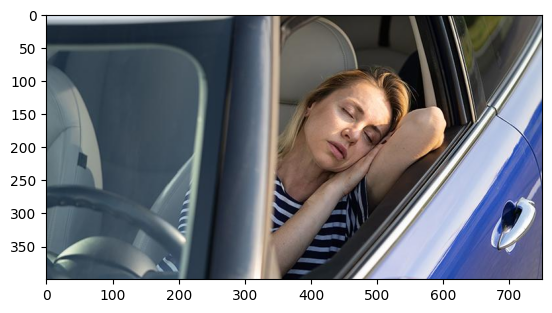

In [36]:
img = cv2.imread(r'C:\Users\HP\Documents\GCP Reimagine\Driver Drowsiness Detection\voiddata\images\3-How-Common-is-Drowsy-Driving.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

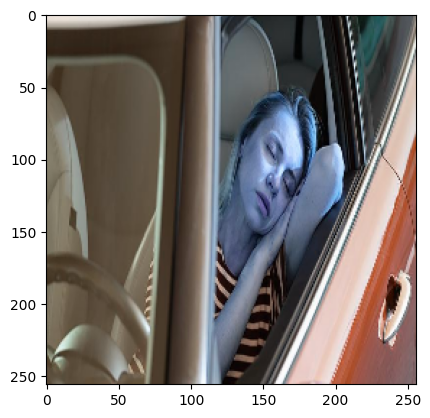

In [37]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 139ms/step


In [39]:
yhat

array([[0.]], dtype=float32)

In [40]:
if yhat > 0.5:
    print(f'Predicted class is Awake')
else:
    print(f'Predicted class is Drowsy')

Predicted class is Drowsy


## Save the Model

In [4]:
from tensorflow.keras.models import load_model

In [34]:
model.save(os.path.join('models','drowsinessdetection.h5'))

In [122]:
new_model = load_model(os.path.join('models','cnnimageclassifier.h5'))

In [124]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 130ms/step


In [125]:
if yhatnew > 0.5:
    print(f'Predicted class is Awake')
else:
    print(f'Predicted class is Drowsy')

Predicted class is Sad


In [3]:
new_model = load_model(r'C:\Users\HP\Desktop\drowsinessdetection.h5')

NameError: name 'load_model' is not defined

In [14]:
def detect_objects_in_video(model, video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame (adjust according to your model's input requirements)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (256, 256))  # Adjust input dimensions
        frame = frame / 255.0  # Normalize pixel values

        # Make predictions using the model
        predictions = model.predict(np.expand_dims(frame, axis=0))

        # Process the predictions and draw bounding boxes
        # (You need to customize this part based on your model's output and the objects you want to detect)

        # Display the frame with detections
        cv2.imshow('Object Detection', frame)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release video capture and close the OpenCV window
    cap.release()
    cv2.destroyAllWindows()

# Replace 'video_path' with the path to your video file
video_path = r'C:\Users\HP\Desktop\1.mp4'
detect_objects_in_video(new_model, video_path)

1/1 [==============================] - 0s 62ms/step


In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model



# Convert to TensorFlow PB model
tf.saved_model.save(new_model, r'C:\Users\HP\Desktop\tf_model') 

INFO:tensorflow:Assets written to: C:\Users\HP\Desktop\tf_model\assets


INFO:tensorflow:Assets written to: C:\Users\HP\Desktop\tf_model\assets


In [3]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
new_model = load_model(r'C:\Users\HP\Desktop\drowsinessdetection.h5')
def detect_objects_in_video(model, video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame (adjust according to your model's input requirements)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (256, 256))  # Adjust input dimensions
        frame = frame / 255.0  # Normalize pixel values

        # Make predictions using the model
        prediction = model.predict(np.expand_dims(frame, axis=0))
        if prediction > 0.5:
            print(f'Predicted class is Awake')
        else:
            print(f'Predicted class is Drowsy')

        # Process the predictions and draw bounding boxes
        # (You need to customize this part based on your model's output and the objects you want to detect)

        # Display the frame with detections
        cv2.imshow('Object Detection', frame)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release video capture and close the OpenCV window
    cap.release()
    cv2.destroyAllWindows()

# Replace 'video_path' with the path to your video file
video_path = r'C:\Users\HP\Desktop\1.mp4'
detect_objects_in_video(new_model, video_path)

1/1 [==============================] - 1s 772ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 83ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 217ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 137ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 104ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 149ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 108ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 88ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 84ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 85ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 64ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 57ms/step
Predicted class is Drowsy
1/1 [==============================] - 0s 88ms/step
Predic